In [1]:
from termcolor import colored

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.datasets import make_multilabel_classification
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization, Flatten
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from utilities import Util
#from Util import Util
import os

In [3]:
smiles_df = pd.read_csv('smiles_converted.csv')
smiles_df = smiles_df.rename(columns={'Name':'Molecule ChEMBL ID'})

In [17]:
training_data = pd.read_csv('Training-Data.csv')
training_data.head()
training_data.isnull().sum()

Molecule ChEMBL ID    0
Smiles                0
CHEMBL614725          0
CHEMBL1957            0
CHEMBL2842            0
CHEMBL203             0
dtype: int64

In [21]:
smiles_df.isnull().sum() > 0

Molecule ChEMBL ID    False
PubchemFP0            False
PubchemFP1            False
PubchemFP2            False
PubchemFP3            False
                      ...  
PubchemFP876          False
PubchemFP877          False
PubchemFP878          False
PubchemFP879          False
PubchemFP880          False
Length: 882, dtype: bool

In [27]:
all_data = pd.merge(training_data, smiles_df, on='Molecule ChEMBL ID')
all_data = all_data.drop(columns=['Smiles', "Molecule ChEMBL ID"])
all_data.head()

,CHEMBL614725,CHEMBL1957,CHEMBL2842,CHEMBL203,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,0,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Prepare the dataset

In [28]:
util_fn = Util(all_data, {'CHEMBL614725', 'CHEMBL1957', 'CHEMBL2842', 'CHEMBL203'})
target_ids = ['CHEMBL614725', 'CHEMBL1957', 'CHEMBL2842', 'CHEMBL203']

In [29]:
def get_dataset():
    y = all_data[target_ids]
    X = all_data.drop(columns=target_ids)
    return X, y

In [30]:
# load dataset
X, y = get_dataset()
n_inputs, n_outputs = X.shape[1], y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# LSTM Model

In [31]:
from tensorflow.keras import regularizers

In [39]:
def lstm_model(n_features, n_outputs):
    model = Sequential()
    model.add(Bidirectional(LSTM(1000, activation='relu', return_sequences=True), input_shape=(1, n_features)))
    model.add(Bidirectional(LSTM(500, activation='relu', return_sequences=True)))
    model.add(Bidirectional(LSTM(500, activation='relu', return_sequences=True)))
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(128))
    model.add(Dense(n_outputs, activation="sigmoid"))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model

## Prepare data for lstm model

In [40]:
n_samples = len(X_train)
n_features = n_inputs
train_X = X_train.to_numpy().reshape(n_samples, 1, n_features)
train_y = y_train.to_numpy()

In [43]:
model = lstm_model(n_inputs, n_outputs)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 1, 2000)           15056000  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 1, 1000)           10004000  
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 1, 1000)           6004000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               128128    
_________________________________________________________________
dense_7 (Dense)              (None, 4)                

In [44]:
history = model.fit(train_X, train_y, epochs=100)

Epoch 1/100
127/127 [==============================] - 41s 260ms/step - loss: 0.4589 - accuracy: 0.5522
Epoch 2/100
127/127 [==============================] - 32s 253ms/step - loss: 0.2809 - accuracy: 0.7331
Epoch 3/100
127/127 [==============================] - 33s 258ms/step - loss: 0.1944 - accuracy: 0.8358
Epoch 4/100
127/127 [==============================] - 35s 273ms/step - loss: 0.1605 - accuracy: 0.8645
Epoch 5/100
127/127 [==============================] - 32s 250ms/step - loss: 0.1355 - accuracy: 0.8836
Epoch 6/100
127/127 [==============================] - 34s 271ms/step - loss: 0.1039 - accuracy: 0.9072
Epoch 7/100
127/127 [==============================] - 32s 254ms/step - loss: 0.0950 - accuracy: 0.9200
Epoch 8/100
127/127 [==============================] - 34s 266ms/step - loss: 0.0891 - accuracy: 0.9225
Epoch 9/100
127/127 [==============================] - 31s 245ms/step - loss: 0.0771 - accuracy: 0.9333
Epoch 10/100
127/127 [==============================] - 32s 251m

127/127 [==============================] - 33s 261ms/step - loss: 0.0060 - accuracy: 0.9740
Epoch 80/100
127/127 [==============================] - 36s 283ms/step - loss: 0.0022 - accuracy: 0.9732
Epoch 81/100
127/127 [==============================] - 39s 310ms/step - loss: 0.0062 - accuracy: 0.9706
Epoch 82/100
127/127 [==============================] - 41s 324ms/step - loss: 0.0047 - accuracy: 0.9684
Epoch 83/100
127/127 [==============================] - 40s 313ms/step - loss: 0.0025 - accuracy: 0.9757
Epoch 84/100
127/127 [==============================] - 35s 278ms/step - loss: 0.0023 - accuracy: 0.9784
Epoch 85/100
127/127 [==============================] - 41s 325ms/step - loss: 0.0021 - accuracy: 0.9760
Epoch 86/100
127/127 [==============================] - 35s 277ms/step - loss: 0.0130 - accuracy: 0.9772
Epoch 87/100
127/127 [==============================] - 50s 397ms/step - loss: 0.0440 - accuracy: 0.9615
Epoch 88/100
127/127 [==============================] - 41s 326ms/st

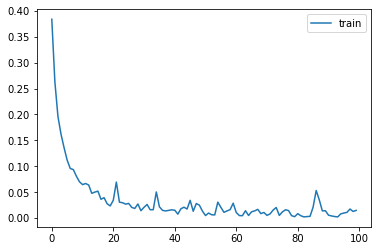

In [45]:
# plt.title('Loss Keras Model')
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

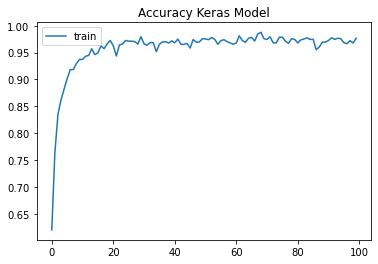

In [46]:
plt.title('Accuracy Keras Model')
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [47]:
n_samples_test = len(X_test)
n_features = n_inputs
test_X = X_test.to_numpy().reshape(n_samples_test, 1, n_features)

In [48]:
y_pred = model.predict(test_X)

y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [49]:
accuracy_score_val = accuracy_score(y_test, y_pred)
accuracy_score_val

0.8919722497522299

In [50]:
accuracy_score_val = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1_measure = 2 * ((precision * recall) / (precision + recall))
print('Calculated Accuracy score: {}, Precision: {}, Recall: {}, \n F1 measure: {} '.format(accuracy_score_val,
                                                            precision, recall, f1_measure))

Calculated Accuracy score: 0.8919722497522299, Precision: 0.9234496124031008, Recall: 0.9041745730550285, 
 F1 measure: 0.9137104506232022 


In [51]:
def get_active_targets(compounds):
    compounds_predicted = {}
    molecule_ids = training_data[training_data["Smiles"].isin(compounds)]["Molecule ChEMBL ID"].tolist()
    compounds = training_data[training_data["Smiles"].isin(compounds)]["Smiles"].tolist()
    finger_prints = smiles_df[smiles_df["Molecule ChEMBL ID"].isin(molecule_ids)]
    drop_columns =  ["Molecule ChEMBL ID"]
    finger_prints = finger_prints.drop(columns=drop_columns)
    n_samples_test = len(finger_prints)
    n_features = n_inputs
    i = 0
    for index, row in finger_prints.iterrows():
        X_new = row.to_numpy().reshape(1, 1, n_features)
        pred = model.predict(X_new)[0]
        print(pred)
        compounds_predicted[compounds[i]] = { 'targets': [], 'prob': []}
        for j in range(0, len(pred)):
            prob = pred[j]
            t = util_fn.target_abbr_from_id(target_ids[j])
            compounds_predicted[compounds[i]]['targets'].append(t)
            compounds_predicted[compounds[i]]['prob'].append(prob)
        i += 1
    
    return compounds_predicted

In [52]:
smiles = ['N#CCCCn1nc(-c2ccc(F)c(O)c2)c2c(N)ncnc21', 
          'CS(=O)(=O)N1CCN(Cc2cc3nc(-c4cccc5[nH]ncc45)nc(N4CCOCC4)c3s2)CC1',
          'Nc1ccc(-c2ccc3ncc4c(=O)[nH]c(=O)n(-c5cccc(C(F)(F)F)c5)c4c3n2)cn1',
          
             ]
finger_print = X_test.iloc[[0]]
compounds = get_active_targets(smiles)
for t in compounds:
    print(colored("Following target probabilites are predicted for Compound: \n {} \n \n".format(t), 'blue'))
    i = 0
    for target in compounds[t]['targets']:
        prob = compounds[t]['prob'][i]
        if prob >= 0.5:
            print(colored("Target {}, Probability {}% \n \n".format( target, round(prob * 100)) , 'green'))
        else:
            print(colored("Target {}, Probability {}% \n \n".format( target, round(prob * 100)) , 'red'))
        i += 1

[0.06167623 0.3519147  0.96322834 0.39984038]
[9.4574690e-04 3.9362907e-04 9.6613610e-01 9.8138702e-01]
[9.9999928e-01 1.2435019e-03 1.0000000e+00 1.5726686e-04]
Following target probabilites are predicted for Compound: 
 Nc1ccc(-c2ccc3ncc4c(=O)[nH]c(=O)n(-c5cccc(C(F)(F)F)c5)c4c3n2)cn1 
 

Target MIA PaCa-2, Probability 6% 
 

Target IGF-1, Probability 35% 
 

Target mTOR, Probability 96% 
 

Target EGFR-erbB1, Probability 40% 
 

Following target probabilites are predicted for Compound: 
 CS(=O)(=O)N1CCN(Cc2cc3nc(-c4cccc5[nH]ncc45)nc(N4CCOCC4)c3s2)CC1 
 

Target MIA PaCa-2, Probability 0% 
 

Target IGF-1, Probability 0% 
 

Target mTOR, Probability 97% 
 

Target EGFR-erbB1, Probability 98% 
 

Following target probabilites are predicted for Compound: 
 N#CCCCn1nc(-c2ccc(F)c(O)c2)c2c(N)ncnc21 
 

Target MIA PaCa-2, Probability 100% 
 

Target IGF-1, Probability 0% 
 

Target mTOR, Probability 100% 
 

Target EGFR-erbB1, Probability 0% 
 



In [57]:
training_data[training_data["Smiles"].isin(smiles)]


,Molecule ChEMBL ID,Smiles,CHEMBL614725,CHEMBL1957,CHEMBL2842,CHEMBL203
493,CHEMBL3903725,Nc1ccc(-c2ccc3ncc4c(=O)[nH]c(=O)n(-c5cccc(C(F)...,0,1,1,1
1452,CHEMBL521851,CS(=O)(=O)N1CCN(Cc2cc3nc(-c4cccc5[nH]ncc45)nc(...,1,0,1,0
2157,CHEMBL1242469,N#CCCCn1nc(-c2ccc(F)c(O)c2)c2c(N)ncnc21,0,0,1,1


In [55]:
cm = multilabel_confusion_matrix(y_test, y_pred)
cm

array([[[871,  12],
        [ 23, 103]],

       [[827,  13],
        [ 31, 138]],

       [[785,  11],
        [ 17, 196]],

       [[420,  43],
        [ 30, 516]]])

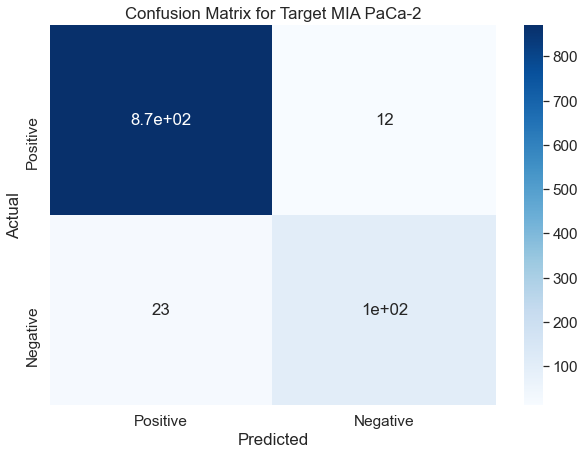

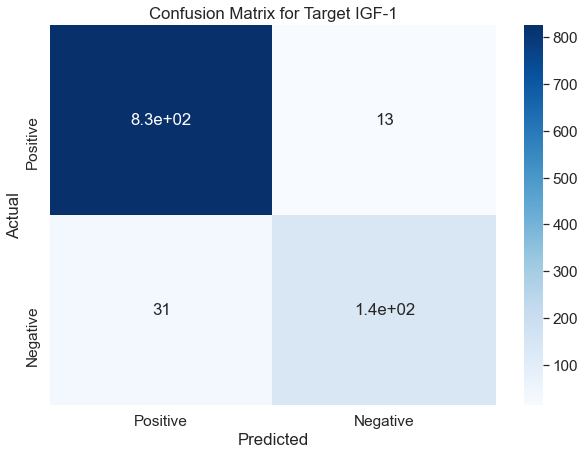

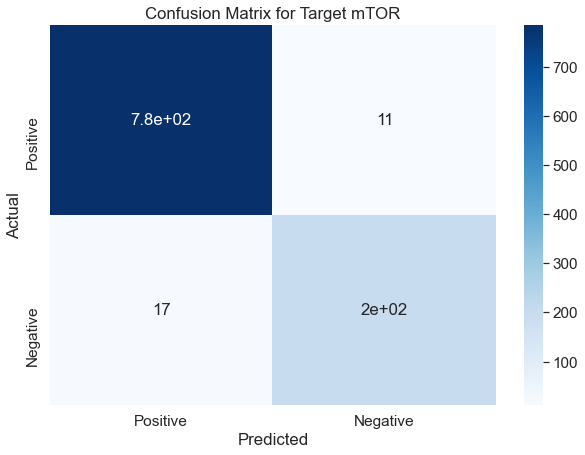

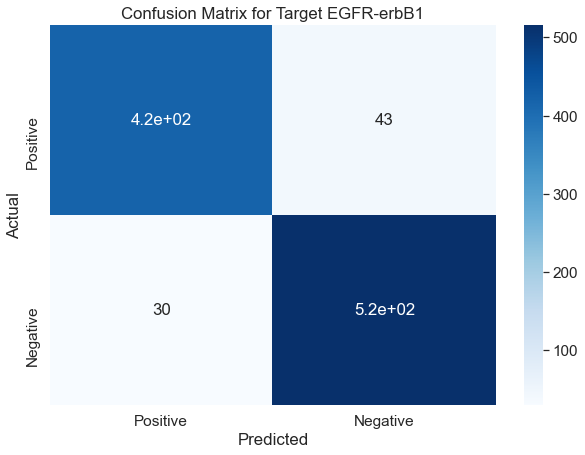

In [56]:
i = 0
for t in cm:
    sns.set(font_scale=1.4)#for label size
    df_cm = pd.DataFrame(t, columns=["Positive", "Negative"], index = ["Positive", "Negative"])
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    plt.title("Confusion Matrix for Target {}".format(util_fn.target_abbr_from_id(target_ids[i])))
    sns.heatmap(df_cm, cmap="Blues", annot=True)
    plt.show()
    i +=1 